# [Intro to Raster Data in Python](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/)
# Chapter 4 Raster Data in Python

In this chapter we wil learn how to use the package **rasterio** combined with **numpy** and **earthpy** to open, manipulate and plot raster data.

We will learn about the key attributes of raster data:

1. Spatial resolution
1. Spatial extent and
1. Coordinate reference systems

## Intro to Rester Data

### What is a Raster
Raster or “gridded” data are stored as a grid of values which are rendered on a map as pixels. Each pixel value represents an area on the Earth’s surface. A raster file is composed of regular grid of cells, all of which are the same size.

We’ve looked at and used rasters before if we’ve looked at photographs or imagery in a tool like Google Earth. However, the raster files that we will work with are different from photographs in that they are spatially referenced. Each pixel represents an area of land on the ground. That area is defined by the spatial resolution of the raster.

*Fun Raster Notes*

* Each cell is called a pixel.
* And each pixel represents an area on the ground.
* The resolution of the raster represents the area that each pixel represents on the ground. So, a 1 meter resolution raster, means that each pixel represents a 1 m by 1 m area on the ground.

A raster dataset can have attributes associated with it as well. For instance, in a Lidar derived digital elevation model (DEM), each cell represents an elevation value for that location on the earth. In a Lidar derived intensity image, each cell represents a Lidar intensity value or the amount of light energy returned to and recorded by the sensor.

> Note: Light Detection and Ranging (LIDAR), is a remote sensing method that uses light in the form of a pulsed laser to measure ranges (variable distances) to the Earth.
> More info: [lidar remote sensing data and the various raster data products derived from lidar data.](https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/)

This means that Raster data can be used to store many different types of scientific data like:

* elevation data
* canopy height models
* surface temperature
* climate model data outputs
* landuse / landcover data






In [1]:
# Import necessary packages
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Use geopandas for vector data and rasterio for raster data
import geopandas as gpd
import rasterio as rio
# Plotting extent is used to plot raster & vector data together
from rasterio.plot import plotting_extent

import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

_**Digital Surface Model (DSM)**_: Elevation at the tops of trees, buildings, etc 

_**Digital Terrain Model (DTM)**_ or _**digital elevation model (DEM)**_: Elevation of the earth's surface



Canopy Height Model (CHM): Actual height of trees, buildings, etc with the influence of the ground elevation removed

CHM = DSM-DTM

## Open Raster Data

### Context Managers to Open and Close Fie Connections
A context manager allows us to open the data and work with it. Within the context manager, Python makes a temporary connection to the file.

Opening and closing files using rasterio and context managers is efficient as it establishes a connection to the raster file rather than directly reading it into memory.

Once we are done opening and reading in the data, the context manager closes that connection to the file. This efficiently ensures that the file won’t be modified later in our code.

The parts of the context manaager are:

>> with rio.open('file-path-here') as file_src:
     dtm_pre_arr = dem_src.read(1, masked=True)

1. `with` statement: creates a connection to eh file. The default connection is read only, meaning that we cannot modify the file by default. This prevents us from making unintended changes to the original data.
1. `rio.open()`: will open a connection to the file with the path provided
1. `file_src`: this is a rasterio reader object that we can use to read in the actual data. We can also use this object to access the metadata for the raster file.
2. The second line of the statement is indented. Any line that is indented below the `with` statement will become part ot the context manager. 



In [2]:
# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# Define relative path to file
dem_pre_path = os.path.join("data", "colorado-flood", "spatial",
                              "boulder-leehill-rd", "pre-flood", "lidar",
                              "pre_DTM.tif")

with rio.open(dem_pre_path) as src:
    # Notice here the src object is printed and returns an "open" DatasetReader object
    print(src, "\n")

# Note that the src object is now closed because it's not within the indented
# part of the context manager above
print(src)

<open DatasetReader name='data/colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif' mode='r'> 

<closed DatasetReader name='data/colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif' mode='r'>


### Exercise
We are going to use the NEON (National Ecological Observatory Network) data

In [3]:
# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# Define relative path to file
dem_pre_path = os.path.join("data","colorado-flood", "spatial",
                              "boulder-leehill-rd", "pre-flood", "lidar",
                              "pre_DTM.tif")

# Open the file using a context manager ("with rio.open" statement)
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1)

print("Numpy Array Shape:", dtm_pre_arr.shape)
print("Object type:", type(dtm_pre_arr))

Numpy Array Shape: (2000, 4000)
Object type: <class 'numpy.ndarray'>


When we open raster data using rasterio, we are creating a numpy array. Numpy is an efficient way to work with and process raster format data. We can plot our data using earthpy `plot_bands()` which takes a numpy array as an input and generates a plot.

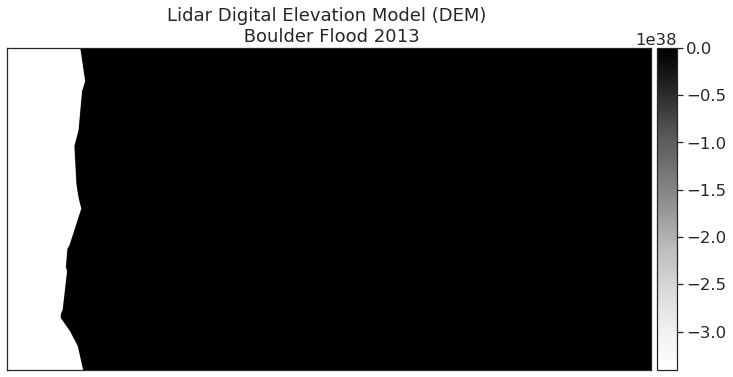

In [4]:
# Plot your data using earthpy
ep.plot_bands(dtm_pre_arr,
              title="Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013",
              cmap="Greys")

plt.show()


The data above should represent terrain model data. However, the range of values is not what is expected. These data are for Boulder, Colorado where the elevation may range from 1000-3000m.

There may be some outlier values in the data that may need to be addressed. Below we check out the min and max values of the data.

the minimum raster value is:  -3.4028235e+38
the maximum raster value is:  2087.43


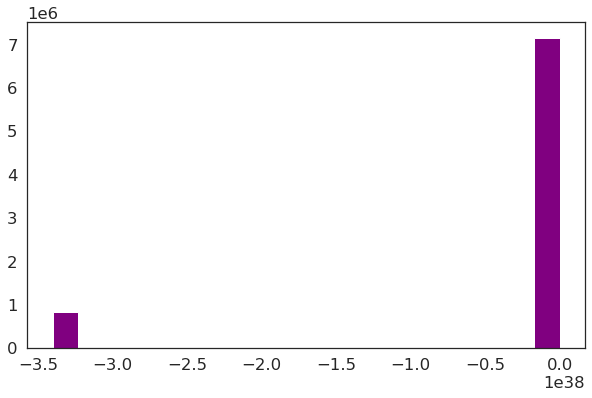

In [5]:
print("the minimum raster value is: ", dtm_pre_arr.min())
print("the maximum raster value is: ", dtm_pre_arr.max())

# A histogram can also be helpful to look at the range of values in your data
# What do you notice about the histogram below?

ep.hist(dtm_pre_arr,
       figsize=(10,6))
plt.show()

Looking at the minimum value of the data, there are two things going on that need to be fixed:

* Check if there should be *nodata* values in the data. *nodata* or invalid elements are pixels we would like to ignore when, for example, merging the image with another image. The negative value of the *nodata* elements might be skewing our plot colors.
* there also could be outlier data in our raster

We can explore the first option - that there are no data values by reading in the data and masking no data values using rasterio. To do this, we will use the `masked=True` parameter for the `.read()` function.

The type of the numpy array created in this way will be `numpy.ma.core.MaskedArray` since we are using to mask the *nodata* values in our data. Masking ensures that when we plot or perfomr arithmetic operations with the data, those *nodata* values are not included in the operation.  

In [6]:
# Read in our data and mask the nodata values
with rio.open(dem_pre_path) as dem_src:
    # Masked=True will mask all nodata values
    dtm_pre_arr = dem_src.read(1, masked=True)


print("the minimum raster value is: ", dtm_pre_arr.min())
print("the maximum raster value is: ", dtm_pre_arr.max())

print("Numpy Array Shape:", dtm_pre_arr.shape)
print("Object type:", type(dtm_pre_arr))

# A histogram can also be helpful to look at the range of values in our data
ep.hist(lidar_dem_im,
       figsize=(10,6),
       title="Histogram of the Data with No Data Values Removed")
plt.show()

# Plot data using earthpy
ep.plot_bands(dtm_pre_arr,
              title="Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013",
              cmap="Greys")

plt.show()

the minimum raster value is:  1676.21
the maximum raster value is:  2087.43
Numpy Array Shape: (2000, 4000)
Object type: <class 'numpy.ma.core.MaskedArray'>


NameError: name 'lidar_dem_im' is not defined

Now the minimum value is within the expected range. Plotting the data again displays what we were expecting.

### Spatial Metadata
A numpy array does not by default store spatial information. However, our raster data is spatial - it represents a location on the earth’s surface.

We can acccess the spatial metadata within the context manager using dem_src.profile. Notice that the .profile object contains information including the *nodata* values for our data, the shape the file type and even the coordinate reference system.

In [7]:
with rio.open(dem_pre_path) as dem_src:
    # lidar_dem_im = dem_src.read(1, masked=True)
    # Create an object called lidar_dem_meta that contains the spatial metadata
    lidar_dem_meta = dem_src.profile

lidar_dem_meta

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4000, 'height': 2000, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(1.0, 0.0, 472000.0,
       0.0, -1.0, 4436000.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

### Plot Raster and Vector Data Together

To plot raster and vector data together on a map, we will need to create an extent object that defines the spatial extent of our raster layer. This will then allow us to plot a raster and vector data together to create a map.

*Exercise* 
We will open a single shapefile that contains a boundary layer that we can overlay on top of our raster dataset.


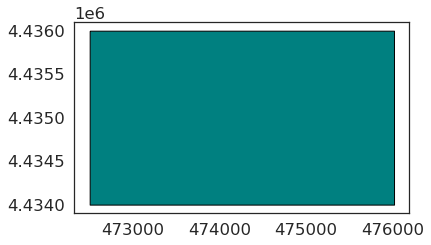

In [8]:
# Open site boundary vector layer
site_bound_path = os.path.join("data","colorado-flood",
                               "spatial",
                               "boulder-leehill-rd",
                               "clip-extent.shp")
site_bound_shp = gpd.read_file(site_bound_path)

# Plot the vector data
site_bound_shp.plot(color='teal',
                    edgecolor='black')
plt.show()

We could try to plot the two datasets together but, since the raster layer does not have spatial information associated with it, the output would look wrong.

In [9]:
# fig, ax = plt.subplots(figsize=(4,10))

# ep.plot_bands(dtm_pre_arr, ax=ax)

# site_bound_shp.plot(color='teal',
#                     edgecolor='black', ax=ax)

# plt.show()

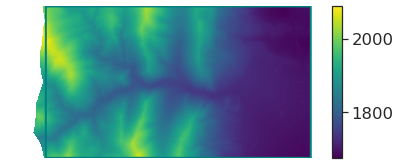

In [10]:
with rio.open(dem_pre_path) as dem_src:
    lidar_dem_im = dem_src.read(1, masked=True)
    # Create an object called lidar_dem_meta that contains the spatial metadata
    lidar_dem_plot_ext = plotting_extent(dem_src)

# This plotting extent object will be used below to ensure our data overlay correctly
lidar_dem_plot_ext

fig, ax = plt.subplots()

#the extent= parameter specifies the plotting extent within ep.plot_bands()
ep.plot_bands(dtm_pre_arr,
# lidar_dem_im,
              ax=ax,
              extent=lidar_dem_plot_ext,
              cmap = 'viridis')

site_bound_shp.plot(color='None',
                    edgecolor='teal',
                    linewidth=2,
                    ax=ax)
# Turn off the outline or axis border on your plot
ax.axis('off')
plt.show()

## Plot Raster Histograms
Histograms represent the distribution of the values in our data and is useful to:

1. Identify outlier data values
1. Assess the min and max values in our data
1. Explore the general distribution of values in the data - e.g. when exploring the distribution of pixel levation values, explore if the area generally flat, hilly, is it high elevation or low elevation.

What does a histogram tell us?

1. How the data is distributed. Each bar in the plot represents the number or frequency of pixels that fall within the range specified by the bin. we can use the `bins=` argument to change the number of breaks in our histogram.
1. We couls also specify the individual break poit=nt to use
   * e.g. bins=[1600, 1800, 2000, 2100]
   

It is better to remove the `NaN` values before plotting a histogram. To do this we would:

1. flatten the data using `ravel()`
1. remove `NaN` values

Another option is to remove the `NaN` values using a mask as seen before.

(2000, 4000)
(8000000,)


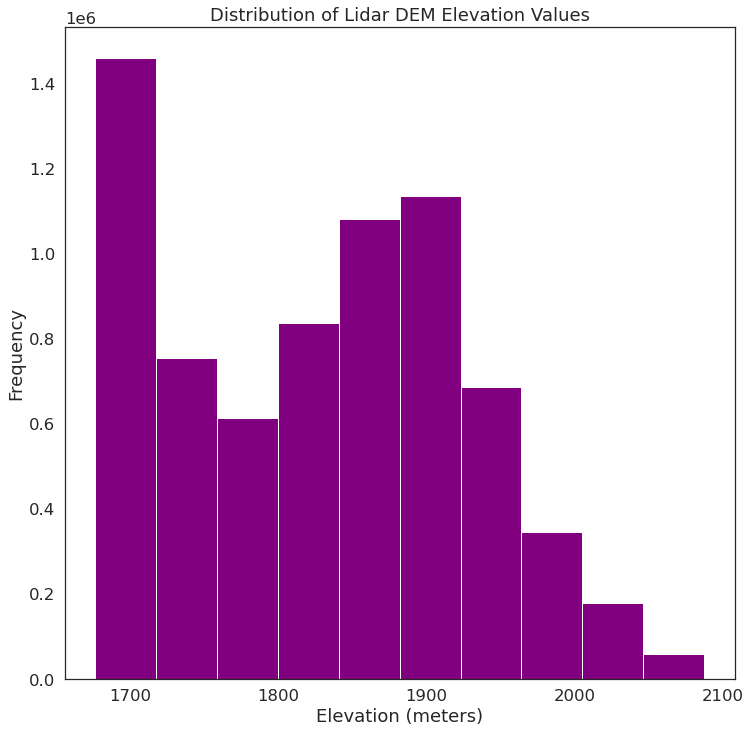

In [11]:
# Get data and set wd
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# Define relative path to file
lidar_dem_path = os.path.join("data", "colorado-flood", "spatial", 
                              "boulder-leehill-rd", "pre-flood", "lidar",
                              "pre_DTM.tif")

# Open data and assign negative values to nan
with rio.open(lidar_dem_path) as src:
    lidar_dem_im = src.read(1, masked=True)

# View object dimensions
print(lidar_dem_im.shape)

# The .ravel method turns an 2-D numpy array into a 1-D vector
print(lidar_dem_im.ravel().shape)

ep.hist(lidar_dem_im, colors=['purple'],
        title="Distribution of Lidar DEM Elevation Values",
        xlabel='Elevation (meters)',
        ylabel='Frequency',
        bins = 10)
plt.show()

## Raster Metadata

A Raster dataset has 3 main spatial attributes:

1. spatial extent
1. CRS
1. resolution

### CRS
CRS locates the raster in a geographic space and specifies the mathematical method that should be used to "flatten" or project the raster in geographic space.




In [12]:
# Import necessary packages
import os
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, mapping
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show

# Package created for the earth analytics program
import earthpy as et

# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# Define relative path to file
lidar_dem_path = os.path.join("data", "colorado-flood", "spatial", 
                              "boulder-leehill-rd", "pre-flood", "lidar",
                              "pre_DTM.tif")

# View crs of raster imported with rasterio
with rio.open(lidar_dem_path) as src:
    print(src.crs)

# Assign crs to myCRS object
myCRS = src.crs

print("CRS.from_epsg: ", myCRS)

EPSG:32613
CRS.from_epsg:  EPSG:32613


In order to determine the metadata for a given EPSG code, we can convert the EPSG code into a Proj4 string with rasterio.

In [13]:
# Each key of the dictionary is an EPSG code
print(list(et.epsg.keys())[:10], "\n")

# You can convert to proj4 like so:
proj4 = et.epsg['32613']
print(proj4)

# Finally you can convert this into a rasterio CRS like so:
crs_proj4 = rio.crs.CRS.from_string(proj4)
crs_proj4

['29188', '26733', '24600', '32189', '4899', '29189', '26734', '7402', '26951', '29190'] 

+proj=utm +zone=13 +datum=WGS84 +units=m +no_defs


CRS.from_epsg(32613)

* +proj=utm The projection of the dataset. Our data is in Universal Transverse Mercator (UTM).
* +zone=18 The UTM projection divides up the world into zones, this element tells us which zone the data is in. Harvard Forest is in Zone 18.
* +datum=WGS84 The datum was used to define the center point of the projection. Our raster uses the WGS84 datum.
* +units=m This is the horizontal units that the data is in. Our units are meters.

### Spatial Extent

The extent is the geographic rectangular area that the raster data covers. If the data is not rectangular, the extent covers the extreme values or edges, and might cover portions where there are no data.

We can use the `.bounds` method to get the extent 



In [14]:
src.bounds

BoundingBox(left=472000.0, bottom=4434000.0, right=476000.0, top=4436000.0)

### Raster Resolution
resolution represents the area on the ground covered by each pixel in the units specified by the CRS. 

We can use the `.res` method to see the resolution 

In [15]:
# What is the x and y resolution for your raster data?
src.res

(1.0, 1.0)

## Geotiff (.tif) File Format

A GeoTIFF is a standard .tif or image file format that includes additional spatial (georeferencing) information embedded in the .tif file as tags called tif tags. These tags can include the following raster metadata:

* Spatial Extent: Area covered by the dataset
* Coordinate reference system: What spatial projection / coordinate reference system is used to store the data? Will it line up with other data?
* Resolution: What area on the ground does each pixel cover - i.e. What is its spatial resolution?
* nodata value: How is the *nodata* represented?
* How many layers are in the .tif file.
* mask associated with the data. values =0 are nodata values whereas = 255 are usable data values.
* data format

We can also extract or view individual metadata attributes.

With geotiffs, the spatial information that describes the raster data are embedded within the file itself.







In [16]:
# Import necessary packages
import os
import rasterio as rio
import earthpy as et

# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# Define relative path to file
lidar_dem_path = os.path.join("data", "colorado-flood", "spatial", 
                              "boulder-leehill-rd", "pre-flood", "lidar",
                              "pre_DTM.tif")

with rio.open(lidar_dem_path) as lidar_dem:
    #extent
    lidar_dem.bounds
# spatial resolution?
lidar_dem.res

# View generate metadata associated with the raster file
lidar_dem.meta

print(lidar_dem.tags(ns='IMAGE_STRUCTURE'))

# View image structure
with rio.open(lidar_dem_path) as lidar_dem:
    print(lidar_dem.tags(ns='IMAGE_STRUCTURE'))
    lidar_dem_mask = lidar_dem.dataset_mask()

# View data mask
print(lidar_dem_mask)

{}
{'COMPRESSION': 'LZW', 'INTERLEAVE': 'BAND'}
[[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]]


After extracting the metadata, we can perform tests on the data.

e.g. compare between two datasets

In [17]:
# Define relative path to file
lidar_dsm_path = os.path.join("data", "colorado-flood", "spatial", 
                              "boulder-leehill-rd", "pre-flood", "lidar",
                              "pre_DSM.tif")

# Open lidar dsm
with rio.open(lidar_dsm_path) as lidar_dsm:
    extent_lidar_dsm = lidar_dsm.bounds 

if lidar_dem.bounds == lidar_dsm.bounds:
    print("Both datasets cover the same spatial extent")

# Do both layers have the same spatial resolution?
if lidar_dsm.res == lidar_dem.res:
    print("Both datasets have the same resolution")


Both datasets cover the same spatial extent
Both datasets have the same resolution


### Single Layer (or Band) vs Multi-layer (Band Geotiffs)

We can see how many layers a raster object has by:
* using the `count()` function 
* seeing the `indexes` attribute


In [18]:
print(lidar_dem.count)

# How many bands / layers does the object have?
print("number of bands", lidar_dem.indexes)

1
number of bands (1,)


## Exercises

Challenge 1: Open And Plot Hillshade
It’s time to practice your raster skills. Do the following:

Use the pre_DTM_hill.tif layer in the colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar directory.

Open the pre_DTM_hill.tif layer using rasterio.
Plot the data using ep.plot_bands().
Set the colormap (cmap=) parameter value.
Give you plot a title.


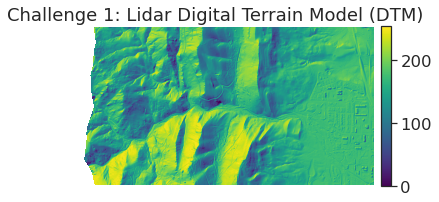

In [19]:
# Here
lidar_dsm_path = os.path.join("data", "colorado-flood", "spatial", 
                              "boulder-leehill-rd", "pre-flood", "lidar",
                              "pre_DTM_hill.tif")

# Open lidar dsm
with rio.open(lidar_dsm_path) as lidar_dsm:
    lidar_dem_im = lidar_dsm.read(1, masked=True) 

fig, ax = plt.subplots()

# ep.plot_bands()
ep.plot_bands(lidar_dem_im,
              ax=ax,
              extent=lidar_dem_plot_ext,
              cmap = 'viridis',
              title="Challenge 1: Lidar Digital Terrain Model (DTM)")

# Turn off the outline or axis border on your plot
ax.axis('off')
plt.show()

Challenge 2: Overlay DTM Over DTM Hillshade
In the challenge above, you opened and plotted a hillshade of the lidar digital terrain model create from NEON lidar data before the 2013 Colorado Flood. In this challenge, you will use the hillshade to create a map that looks more 3-dimensional by overlaying the DTM data on top of the hillshade.

To do this, you will need to plot each layer using ep.plot_bands()

1. Plot the hillshade layer pre_DTM_hill.tif that you opened in Challenge 1. Similar to Challenge one set cmap="Greys"
1. Plot the DTM that you opened above dtm_pre_arr
   * When you plot the DTM, use the alpha= parameter to adjust the opacity of the DTM so that you can see the shading on the hillshade underneath the DTM.
   * Set the colormap to viridis (or any colormap that you prefer) cmap='viridis' for the DTM layer.
HINT: be sure to use the ax= parameter to make sure both layers are on the same figure.

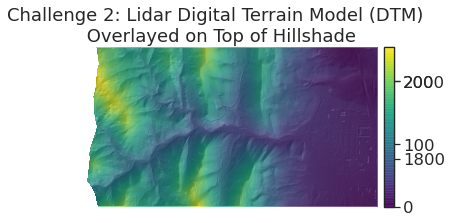

In [20]:
lidar_dsm_path = os.path.join("data", "colorado-flood", "spatial",
                              "boulder-leehill-rd", "pre-flood", 
                              "lidar",
                              "pre_DTM_hill.tif")

# Open lidar dsm
with rio.open(lidar_dsm_path) as lidar_dsm:
    lidar_dem_im = lidar_dsm.read(1, masked=True) 
    lidar_dem_im_plot_ext = plotting_extent(lidar_dsm)


# Define relative path to file
dem_pre_path = os.path.join("data","colorado-flood", "spatial",
                              "boulder-leehill-rd", "pre-flood",
                              "lidar",
                              "pre_DTM.tif")

# Open the file using a context manager ("with rio.open" statement)
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1, masked=True)
    dtm_pre_arr_plot_ext = plotting_extent(dem_src)



fig, ax = plt.subplots()

# ep.plot_bands() lidar_dem_im
ep.plot_bands(lidar_dem_im,
              ax=ax,
              extent=lidar_dem_im_plot_ext,
              cmap = 'gray_r')

#   ep.plot_bands() lidar_dem_im
ep.plot_bands(dtm_pre_arr,
              ax=ax,
              extent=dtm_pre_arr_plot_ext,
              cmap = 'viridis',
              alpha = 0.7,
              title="Challenge 2: Lidar Digital Terrain Model (DTM) \n Overlayed on Top of Hillshade")

# Turn off the outline or axis border on your plot
ax.axis('off')
plt.show()



Challenge 3: Add A Site Boundary to Your Raster Plot
Take all of the code that you wrote above to plot the DTM on top of your hillshade layer. Add the site boundary layer that you opened above site_bound_shp to your plot.

HINT: remember that the plotting_extent() object (lidar_dem_plot_ext) will be needed to add this final layer to your plot.

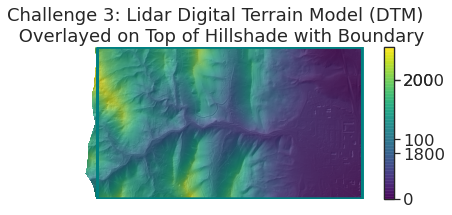

In [21]:
lidar_dsm_path = os.path.join("data", "colorado-flood", "spatial",
                              "boulder-leehill-rd", "pre-flood", 
                              "lidar",
                              "pre_DTM_hill.tif")

# Open lidar dsm
with rio.open(lidar_dsm_path) as lidar_dsm:
    lidar_dem_im = lidar_dsm.read(1, masked=True) 
    lidar_dem_im_plot_ext = plotting_extent(lidar_dsm)


# Define relative path to file
dem_pre_path = os.path.join("data","colorado-flood", "spatial",
                              "boulder-leehill-rd", "pre-flood",
                              "lidar",
                              "pre_DTM.tif")

# Open the file using a context manager ("with rio.open" statement)
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1, masked=True)
    dtm_pre_arr_plot_ext = plotting_extent(dem_src)


# Open site boundary vector layer
site_bound_path = os.path.join("data","colorado-flood",
                               "spatial",
                               "boulder-leehill-rd",
                               "clip-extent.shp")
site_bound_shp = gpd.read_file(site_bound_path)




fig, ax = plt.subplots()

# ep.plot_bands() lidar_dem_im
ep.plot_bands(lidar_dem_im,
              ax=ax,
              extent=lidar_dem_im_plot_ext,
              cmap = 'gray_r')

#   ep.plot_bands() lidar_dem_im
ep.plot_bands(dtm_pre_arr,
              ax=ax,
              extent=dtm_pre_arr_plot_ext,
              cmap = 'viridis',
              alpha = 0.7,
              title="Challenge 3: Lidar Digital Terrain Model (DTM) \n Overlayed on Top of Hillshade with Boundary")
              
site_bound_shp.plot(color='None',
                    edgecolor='teal',
                    linewidth=3,
                    ax=ax)


# Turn off the outline or axis border on your plot
ax.axis('off')
plt.show()

# Chapte 5: Processing Raster Data

In this chapter we will learn how to process raster data by cropping, reprojecting and reclassifying.

## Subtract Rasters & Export Geotiffs

Often time we will need to process two raster datasets together to create a new raster output, and then save that output as a new file. In this lesson, we will learn how to subtract rasters and create a new GeoTIFF file.


In [22]:
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import rasterio as rio
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

## Get the Digital elevation model (DEM) also called DIgital Terrain Model (DTM)

# Define relative path to file
lidar_dem_path = os.path.join("data", "colorado-flood", "spatial",
                              "boulder-leehill-rd", "pre-flood",
                               "lidar",
                              "pre_DTM.tif")

# Open raster data
with rio.open(lidar_dem_path) as lidar_dem:
    lidar_dem_im = lidar_dem.read(1, masked=True)
    
    # Get bounds for plotting
    bounds = plotting_extent(lidar_dem)

## Get the Digital Surface Model (DSM)

# Define relative path to file
lidar_dsm_path = os.path.join("data", "colorado-flood", "spatial", 
                              "boulder-leehill-rd", "pre-flood", "lidar",
                              "pre_DSM.tif")

with rio.open(lidar_dsm_path) as lidar_dsm:
    lidar_dsm_im = lidar_dsm.read(1, masked=True)
    
lidar_dsm_im




masked_array(
  data=[[--, --, --, ..., 1695.6300048828125, 1695.5899658203125,
         1696.3900146484375],
        [--, --, --, ..., 1695.5999755859375, 1695.6300048828125, 1697.0],
        [--, --, --, ..., 1695.3800048828125, 1695.43994140625,
         1695.449951171875],
        ...,
        [--, --, --, ..., 1681.449951171875, 1681.3900146484375, 1681.25],
        [--, --, --, ..., 1681.719970703125, 1681.5699462890625,
         1681.5599365234375],
        [--, --, --, ..., 1681.8900146484375, 1681.8099365234375,
         1681.739990234375]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-3.402823e+38,
  dtype=float32)

### Canopy Height Model

The canopy height model (CHM) represents the height of the trees or buildings in the ground. It is the difference between the DEM and DSM. It is not an elevation value, rather it’s the height or distance between the ground and the top of the objects in the ground.

> **Reminder:** Before subtracting the two datasets make sure both cover the same area and have the same resolution.



Is the spatial extent the same? True
Is the resolution the same? True


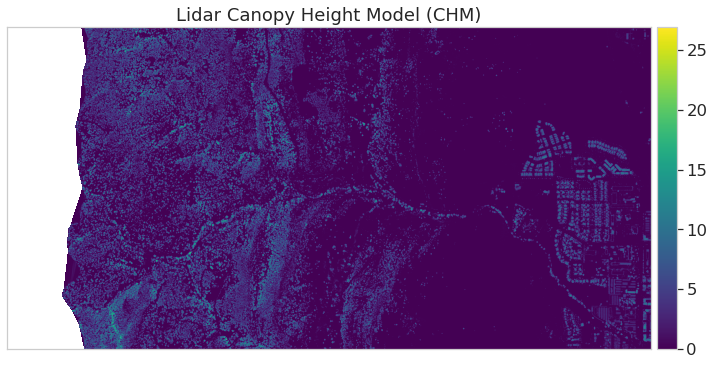

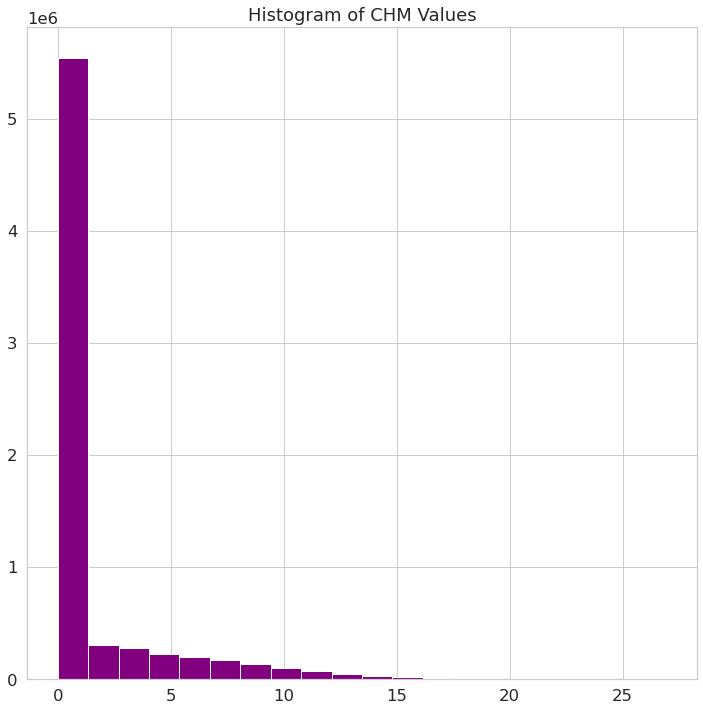

In [27]:
# Are the bounds the same?
print("Is the spatial extent the same?", 
      lidar_dem.bounds == lidar_dsm.bounds)

# Is the resolution the same ??
print("Is the resolution the same?", 
      lidar_dem.res == lidar_dsm.res)

      # Calculate canopy height model
lidar_chm_im = lidar_dsm_im - lidar_dem_im

# Plot the data
ep.plot_bands(lidar_chm_im, 
              cmap='viridis',
              title="Lidar Canopy Height Model (CHM)",
              scale=False)
plt.show()

ep.hist(lidar_chm_im, 
        colors = 'purple',
        title="Histogram of CHM Values")
plt.show()


Check that the minimum and maximum value make sense. Think that you are sensing things like trees and buildings. 

In [28]:
print('CHM minimum value: ', lidar_chm_im.min())
print('CHM max value: ', lidar_chm_im.max())


CHM minimum value:  0.0
CHM max value:  26.930054


### Exporting a Raster

It is a good idea to create an `outputs`directory before exporting the raster file. This structure will allow us to keep things organized.

Then, we need to consider the metdata associated with our CHM. The CHM was generated using 2 numpy arrays and neither of these arrays has spatial data directly associated with it. However, we do have the rasterio object that has metadata we can use if we want to assign all of the spatial attributes that are needed to save a usable geotiff file.

We can take advantage of this process and change some of the metadata. FOr example, let's change the value of the *nodata* for something we can remember more easily: `-999.99`. For this we will:

1. Assign all masked pixels values which represent nodata values to -999.99 using the `np.ma.filled()` function.

1. Create a new metadata dictionary that contained the updated nodata value.

Finally, to export the file we can do:

1. use the same `rio.open()` syntax we used to to read the file, except now we specify we are writing a new file with the ‘w’ argument.
1. specify the new file name and destination in the rio.open() function eg: 'data/colorado-flood/spatial/outputs/lidar_chm.tiff'
1. specify the metadata as an “unpacked” dictionary using **chm_meta- doing this allow us to NOT have to specify EACH and EVERY metadata element individually in our output statement - which would be tedious!
1. finally, write the file. output_file.write(your-object-name, layer) Notice that when we make this call we specify both the object name and the layer that we wish to write to a new file. Also notice the outf is the name of the rasterio object as defined below.


In [40]:
if os.path.exists('data/colorado-flood/spatial/outputs'):
    print('The directory exists!')
else:
    os.makedirs('data/colorado-flood/spatial/outputs')

## Taking a look to the lidar_dem metadata dictionary

print("\nlidar_dem metadata: ", lidar_dem.meta, "\n")

print("cmh minimum value before changing *nodata*: ", lidar_chm_im.min())

# fill the masked pixels with a set no data value
nodatavalue = -999.0
lidar_chm_im_fi = np.ma.filled(lidar_chm_im, fill_value=nodatavalue)
lidar_chm_im_fi.min(), nodatavalue

print("cmh minimum value after changing *nodata*: ", lidar_chm_im_fi.min(), "\n")

# Update the metadata to ensure the nodata value is properly documented 

# Create dictionary copy
chm_meta = lidar_dem.meta.copy()

# Update the nodata value to be an easier to use number
chm_meta.update({'nodata': nodatavalue})
print("chm metadata: ", chm_meta)

out_path = os.path.join("data", "colorado-flood", "spatial",
                        "outputs", "lidar_chm.tif")

with rio.open(out_path, 'w', **chm_meta) as outf:
    outf.write(lidar_chm_im_fi, 1)



The directory exists!

lidar_dem metadata:  {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4000, 'height': 2000, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(1.0, 0.0, 472000.0,
       0.0, -1.0, 4436000.0)} 

cmh minimum value before changing *nodata*:  0.0
cmh minimum value after changing *nodata*:  -999.0 

chm metadata:  {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -999.0, 'width': 4000, 'height': 2000, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(1.0, 0.0, 472000.0,
       0.0, -1.0, 4436000.0)}


### Challenge: Load the data we just exported and plot it

In [45]:
# Define relative path to file
lidar_chm_path = os.path.join("data", "colorado-flood", "spatial",
                              "outputs",
                              "lidar_chm.tif")

# Open raster data
with rio.open(lidar_chm_path) as lidar_chm:
    lidar_chm_im = lidar_chm.read(1, masked=True)

print("bounds: ", lidar_chm.bounds)
print("res: ", lidar_dem.res)


# Open lidar dsm
with rio.open(lidar_dsm_path) as lidar_dsm:
    lidar_dem_im = lidar_dsm.read(1, masked=True) 
    lidar_dem_im_plot_ext = plotting_extent(lidar_dsm)


# Plot the data
ep.plot_bands(lidar_chm_im, 
              cmap='viridis',
              title="Lidar Canopy Height Model (CHM)",
              scale=False,
              ax = ax)
plt.show()


bounds:  BoundingBox(left=472000.0, bottom=4434000.0, right=476000.0, top=4436000.0)
res:  (1.0, 1.0)


## Classify and Plot Raster

### Manually Reclassify Raster Data

When we are reclassiying a raster we are mapping each pixel into a new value based on some rule following these steps:

1. Data import/cleanup: load and clean the data. This includes cropping, simplifying (if needed) and removing *nodata* values.
1. Data Exploration: understand the range and distribution of values in the data. This may involve plotting histograms and scatter plots to determine what classes are appropriate for our data.
1. Reclassify the Data: Once you understand the distribution of your data, you are ready to reclassify. There are statistical and non-statistical approaches to reclassification. Here you will learn how to manually reclassify a raster using bins that you define in your data exploration step.

In [46]:
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import rasterio as rio
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
import seaborn as sns
sns.set(font_scale=1.5, style="whitegrid")

# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# Define relative paths to DTM and DSM files
dtm_path = os.path.join("data", "colorado-flood", "spatial",
                        "boulder-leehill-rd", "pre-flood", "lidar",
                        "pre_DTM.tif")

dsm_path = os.path.join("data", "colorado-flood", "spatial",
                        "boulder-leehill-rd", "pre-flood", "lidar",
                        "pre_DSM.tif")

# Open DTM and DSM files
with rio.open(dtm_path) as src:
    lidar_dtm_im = src.read(1, masked=True)
    spatial_extent = plotting_extent(src)

with rio.open(dsm_path) as src:
    lidar_dsm_im = src.read(1, masked=True)
    spatial_extent = plotting_extent(src)

# Create canopy height model (CHM)    
lidar_chm_im = lidar_dsm_im - lidar_dtm_im
lidar_chm_im



masked_array(
  data=[[--, --, --, ..., 0.0, 0.1700439453125, 0.9600830078125],
        [--, --, --, ..., 0.0, 0.090087890625, 1.6400146484375],
        [--, --, --, ..., 0.0, 0.0, 0.0799560546875],
        ...,
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-3.402823e+38,
  dtype=float32)

### Classification

There are many appoaches to classification. Some use highly sophisticated spatial algorithms that identify patterns in the data that can in turn be used to classify particular pixels into particular “classes”.

In this case, we are simply going to create the classes manually using the range of quantitative values found in our data.

Assuming that our data represent trees (though we know there are likely some buildings in the data), classify our raster into 3 classes:

* Short trees
* Medium trees
* Tall trees
To perform this classification, we need to understand which values represent short trees vs medium trees vs tall trees in our raster. This is where histograms can be extremely useful.

Let's start by looking at the min and max values in our CHM and the histogram.

Using the histogram we can further explore the data by zooming in. This is done by constraining the x axis limits using the `xlim` and `ylim` parameters.

We can also modify the number of bins in the plot with the `bins` parameter.

We can also collect the outputs of the histogram.


CHM min value: 0.0
CHM max value: 26.930054


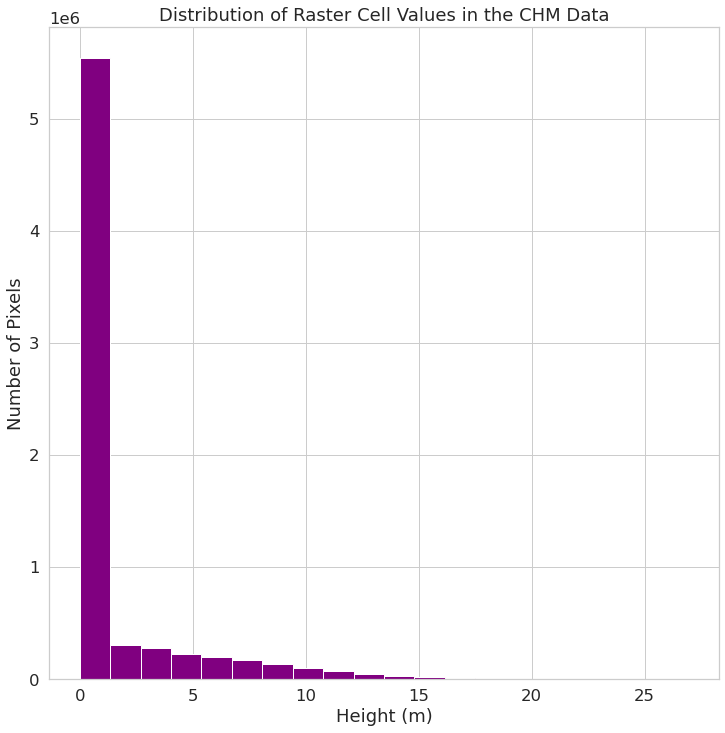

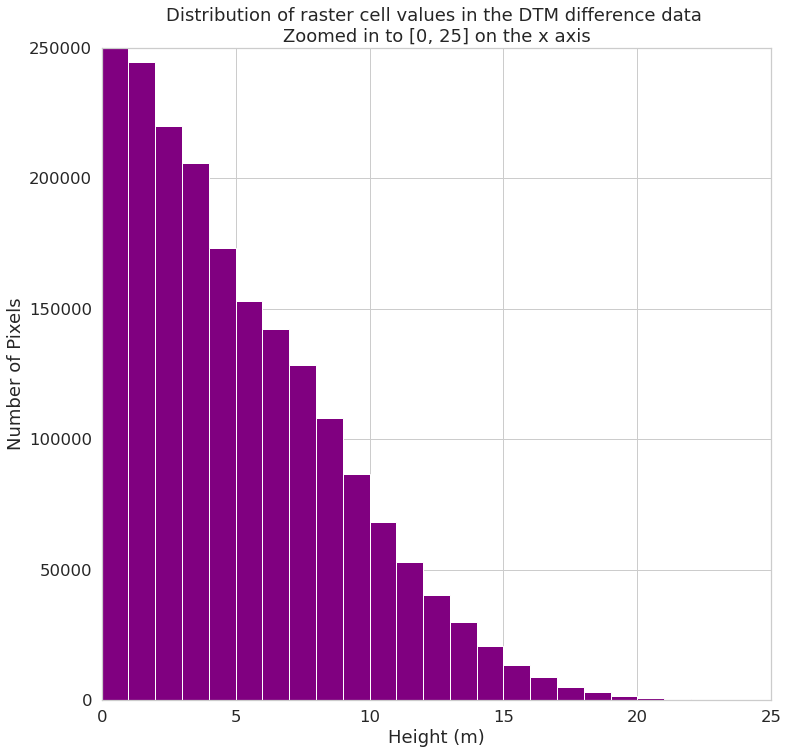

counts: [5448102  244588  220138  206107  173181  153057  142190  128682  108321
   86867   68319   52981   40233   29871   20826   13699    8784    5260
    3118    1733     883     431     212      91]
bins: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


In [51]:
# View min and max values in the data
print('CHM min value:', lidar_chm_im.min())
print('CHM max value:', lidar_chm_im.max())

ep.hist(lidar_chm_im.ravel(),
        title="Distribution of Raster Cell Values in the CHM Data",
        xlabel="Height (m)",
        ylabel="Number of Pixels")

plt.show()

# Create histogram with xlim and ylim
xlim = [0, 25]

f, ax = ep.hist(lidar_chm_im.ravel(),
                hist_range=xlim,
                bins=range(*xlim),
                ylabel="Number of Pixels", xlabel="Height (m)",
                title="Distribution of raster cell values in the DTM difference data \n" +
                      "Zoomed in to {} on the x axis".format(xlim))

ax.set(xlim=xlim, ylim=[0, 250000])

plt.show()

# Get counts and bins
counts, bins = np.histogram(lidar_chm_im,
                            bins=range(*xlim), 
                            range=xlim)

print("counts:", counts)
print("bins:", bins)

We can create custome breaks for the histogram, for example following this rule:
* 0 - 2 = no trees
* 2 - 7 = short trees
* 7 - 12 = medium trees
* '> 12 = tall trees

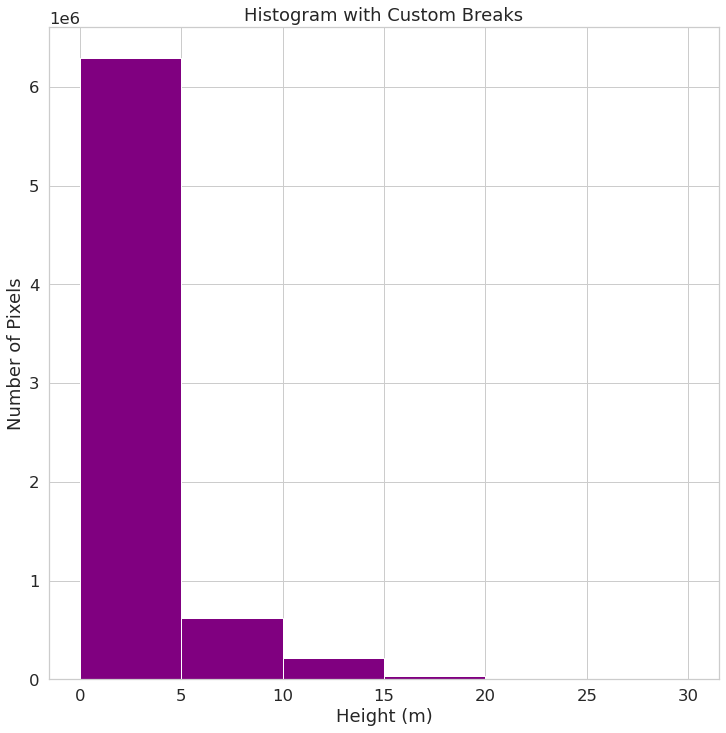

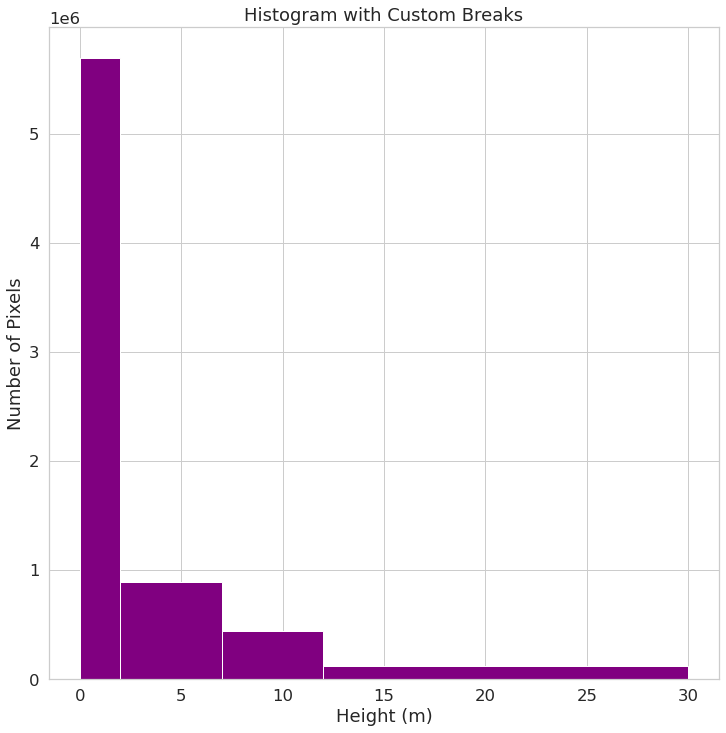

In [53]:
# Histogram with custom breaks
ep.hist(lidar_chm_im.ravel(),
        bins=[0, 5, 10, 15, 20, 30],
        title="Histogram with Custom Breaks",
        xlabel="Height (m)", 
        ylabel="Number of Pixels")

plt.show()

ep.hist(lidar_chm_im.ravel(),
        colors='purple',
        bins=[0, 2, 7, 12, 30],
        title="Histogram with Custom Breaks",
        xlabel="Height (m)",
        ylabel="Number of Pixels")

plt.show()

### Map Raster Values to New Values
1. Create reclassification matrix

This matrix maps a range of values to a new defined value.

* No trees: (0m - 2m tall) = NA
* Short trees: (2m - 7m tall) = 1
* Medium trees: (7m - 12m tall) = 2
* Tall trees: (> 12m tall) = 3

Our assignment would be as follows:
* 0 - 2 meters -> 1
* 2 - 7 meters -> 2 (short trees)
* 7 - 12 meters -> 3 (medium trees)
* '> 12 or 12 - Inf -> 4 (tall trees)

A function useful for classifying values is numpy's `digitize`. It also divides the data into bins and then replace each datapoint with the integer corresponding to the bin it belongs to. 

* By default, the bins include the starting value of the range but not the ending value. The ending value of the will be the beginning of the next bin. The argument right = True will include the second value in the bin but not the first.
* Any values below the first bin will be assigned a 0. Any value above the highest value of all bins will be assigned the next value available (if we have 4 bins, a 5 will be assigned). 

Often we can use `np.inf` and `-np.inf` as the limits of the bins to include all values greater than the last value and smaller than the first. However, when using the class bins for a `BoundaryNorm` object for a plot, `np.inf` will throw an error in matplotlib. A quick solution is to use the maximum and minimum value numpy can store as an integer. This can be accesed using `np.iinfo(np.int32).max' and `np.iinfo(np.int32).min'.



In [ ]:
# Check fill value for your array
lidar_chm_im.fill_value

